# Statistical analysis of curated parameter values

This notebook illustrates how the parameter values available in an annotation corpus can be used to perform simple statistical analyses.

**NOTE**: These analyses are for demonstration purpose only. Their outcome should not be interpreted as indicative a genuine relationships, the data sample being too sparse and heterogeneous at that point to claim any scientific validity for the conclusion of the analyses demonstrated here.

### Downloading/updating the corpus

In [1]:
from git import Repo
import os

git_url = "https://github.com/christian-oreilly/corpus-thalamus.git"
repo_dir = os.path.join(os.getcwd(), "neurocuratorDB")
if not os.path.isdir(repo_dir):
    Repo.clone_from(git_url, repo_dir)
else:
    Repo(repo_dir).remotes.origin.pull()

### Imports

In [2]:
# Stadard imports
import sys, os
import matplotlib.pylab as plt
import seaborn as sns
import quantities as pq
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

# NAT imports
from nat.annotationSearch import ParameterSearch, ConditionAtom

/home/oreilly/python_venv/venv-3.4/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Looking at curated ionic current conductances

### Searching for annotated maximal ionic current conductances and showing the first ten records

In [3]:
searcher = ParameterSearch(repo_dir)
searcher.setSearchConditions(ConditionAtom("Parameter name", "conductance_ion_curr_max"))
searcher.expandRequiredTags = True
searcher.onlyCentralTendancy = True
resultDF = searcher.search()
resultDF[["Species", "Text", "Transmembrane ionic current", "Unit",
          "Values", "neuron part"]].head(10)

,Species,Text,Transmembrane ionic current,Unit,Values,neuron part
0,"[{'id': 'NIFORG:birnlex_160', 'name': 'Rat'}]",Table 2,Sodium transient fast current,mS/cm^2,300.000000,
1,"[{'id': 'NIFORG:birnlex_160', 'name': 'Rat'}]",our final model comprised the following: gLEAK...,Leak ionic current,uS/cm^2,150.000000,
2,"[{'id': 'NIFORG:birnlex_167', 'name': 'Mouse'}]",Table 1,Potassium delayed rectifier,S/cm^2,0.005100,dendrite
3,"[{'id': 'NIFORG:birnlex_160', 'name': 'Rat'}]",The gCAN had a conductance\nof 250S/cm2,Calcium activated nonspecific cation current,uS/cm^2,250.000000,
4,"[{'id': 'NIFORG:birnlex_160', 'name': 'Rat'}]",when the difference in\nmembrane surface area ...,Low threshold calcium T-current,pA/um^2,1.300000,neuron part
5,"[{'id': 'NIFORG:birnlex_167', 'name': 'Mouse'}]",Table 1,Sodium transient fast current,S/cm^2,0.180000,Neuronal Cell Body
6,"[{'id': 'NIFORG:birnlex_167', 'name': 'Mouse'}]",Table 1,Low threshold calcium T-current,S/cm^2,0.000012,Neuronal Cell Body
7,"[{'id': 'NIFORG:birnlex_167', 'name': 'Mouse'}]",Table 1,Potassium delayed rectifier,S/cm^2,0.340000,Neuronal Cell Body
8,"[{'id': 'NIFORG:birnlex_160', 'name': 'Rat'}]",When the difference in\nmembrane surface area ...,A current,pS/um**2,9.600000,neuron part
9,[],Table 2-6,Sodium transient fast current,S/cm^2,0.011000,


### Keeping only specific conductances (i.e., conductance per area) and rescaling to a common unit so that numerical values are comparable

In [4]:
isSpecific = []
allConductances = []
for v, u in zip(resultDF["Values"], resultDF["Unit"]):
    try:
        allConductances.append(float(pq.Quantity(v, u).rescale('S/cm**2')))
        isSpecific.append(True)
    except:
        isSpecific.append(False)
        
resultDF = resultDF[isSpecific]
resultDF["Values"] = allConductances      

### Manually normalizing the species and the cell types

In [5]:
def simpleSpecies(species_lst):
    species_strings = []    
    for species in species_lst:
        if "Rat" in species.name or "Sprague Dawley" == species.name:
            species_strings.append("Rat")
        elif "Mouse" in species.name:
            species_strings.append("Mouse")
        elif "catus" in species.name:
            species_strings.append("Cat")
        elif "Guinea" in species.name:
            species_strings.append("Guinea pig")
        elif "furo" in species.name:
            species_strings.append("Ferret")            
        else:
            print("The following species is not taken into account: ", species.name)
            species_strings.append("")
    return np.unique(species_strings)

def simpleCell(cell):
    if "relay" in cell or \
       "Thalamocortical" in cell or \
       "ventroposterior nucleus principal" in cell:
        return "Thalamus relay cell"
    else:
        return cell  

resultOneSpecies = resultDF.reset_index()
resultOneSpecies["Species"] = [simpleSpecies(s) for s in resultOneSpecies["Species"]]
resultOneSpecies = resultOneSpecies[[len(s) == 1 for s in resultOneSpecies["Species"]]].reset_index()
resultOneSpecies["Species"] = [s[0] for s in resultOneSpecies["Species"]]
resultOneSpecies["Cell"] = [simpleCell(s) for s in resultOneSpecies["Cell"]]
resultOneSpecies["Current"] = resultOneSpecies["Transmembrane ionic current"]
resultOneSpecies["log10Values"] = np.log10(resultOneSpecies["Values"])

### Computing a linear regression model of the logarithm of the conductances as function of the species, the current type, and the cell type.

In [6]:
formula = "np.log10(Values) ~ Species + Current + Cell"
lm = ols(formula, data=resultOneSpecies).fit()
table = sm.stats.anova_lm(lm, typ=2) # Type 2 ANOVA DataFrame
table

,sum_sq,df,F,PR(>F)
Species,3.711695,2.0,3.266885,0.053629
Current,70.303119,16.0,7.734746,0.000002
Cell,3.244030,3.0,1.903509,0.152853
Residual,15.338126,27.0,NaN,NaN


In [7]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log10(Values)   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     7.519
Date:                Wed, 10 Oct 2018   Prob (F-statistic):           1.49e-06
Time:                        11:54:02   Log-Likelihood:                -40.728
No. Observations:                  48   AIC:                             123.5
Df Residuals:                      27   BIC:                             162.8
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================
                                                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -2.0808      0.568     -3.665      0.001      -3.246      -0.916
Species[T.Mouse]                                           -0.8030      0.633     -1.268      0.216      -2.102       0.496
Species[T.Rat]                                              0.1200      0.600      0.200      0.843      -1.111       1.351
Current[T.Calcium activated nonspecific cation current]    -1.0354      0.847     -1.223      0.232      -2.773       0.702
Current[T.Calcium-dependent potassium current]             -0.4718      0.673     -0.702      0.489      -1.852       0.908
Current[T.Fast voltage-gated potassium (Kf) current]        1.2657      0.847      1.495      0.147      -0.472       3.003
Current[T.Inward rectifier (h-type) current]               -1.5498      0.586     -2.643      0.014      -2.753      -0.347
Current[T.Leak ionic current]                              -1.2572      0.847     -1.485      0.149      -2.995       0.480
Current[T.Low threshold calcium T-current]                 -0.7393      0.475     -1.557      0.131      -1.714       0.235
Current[T.Potassium delayed rectifier]                      1.6570      0.478      3.466      0.002       0.676       2.638
Current[T.Potassium inward rectifier (Kir) current]        -2.1323      0.847     -2.518      0.018      -3.870      -0.395
Current[T.Potassium leak current]                          -1.5103      0.907     -1.666      0.107      -3.371       0.350
Current[T.Slow calcium-dependent AHP potassium current]    -0.7817      0.673     -1.162      0.255      -2.162       0.598
Current[T.Slow high threshold calcium current]              0.1688      0.847      0.199      0.844      -1.569       1.906
Current[T.Sodium current]                                  -0.4371      0.662     -0.660      0.515      -1.795       0.921
Current[T.Sodium leak current]                             -2.0331      0.907     -2.242      0.033      -3.893      -0.173
Current[T.Sodium pesistent current]                        -1.7699      0.907     -1.952      0.061      -3.630       0.090
Current[T.Sodium transient fast current]                    1.7164      0.465      3.692      0.001       0.763       2.670
Current[T.q- and p-type calcium current]                    0.9469      0.847      1.118      0.273      -0.791       2.684
Cell[T.Thalamic reticular nucleus cell]                    -0.5485      0.441     -1.243      0.224      -1.454       0.357
Cell[T.Thalamus interneuron small]                         -0.4893      0.375     -1.306      0.202      -1.258       0.279
Cell[T.Thalamus relay cell]                                -0.6059      0.268     -2.262      0.032      -1

### Violin plot showing the distribution of the log10 of the conductances, for rats and mice.

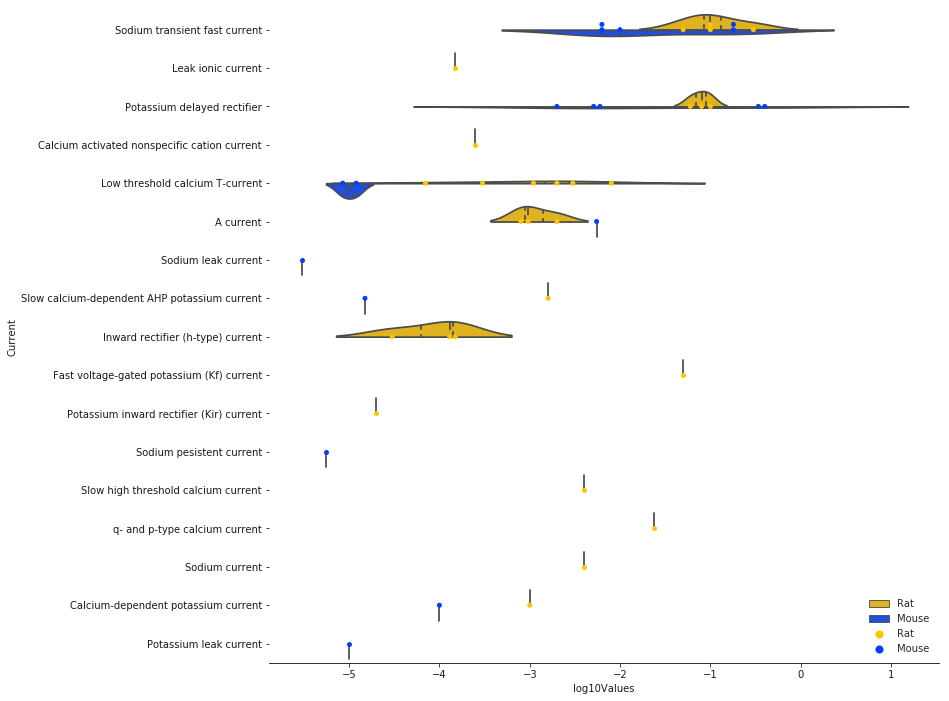

In [8]:
%matplotlib inline

a4_dims = (12, 12)
fig, ax = plt.subplots(figsize=a4_dims)

sns.set(style="whitegrid", palette="bright", color_codes=True)

# Load the example tips dataset
tips = sns.load_dataset("tips")

# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x="log10Values", y="Current", hue="Species", ax=ax,
               data=resultOneSpecies[np.in1d(resultOneSpecies["Species"], ["Rat", "Mouse"])], 
               split=True, inner="quart", palette={"Mouse": "b", "Rat": "y"})
sns.swarmplot(y="Current", x="log10Values", hue="Species", ax=ax,
              data=resultOneSpecies[np.in1d(resultOneSpecies["Species"], ["Rat", "Mouse"])],
              palette={"Mouse": "b", "Rat": "y"})

plt.legend(loc="lower right")
sns.despine(left=True)

### Violin plot showing the distribution of the log10 of the conductances across species (regardless of current types or cell types).

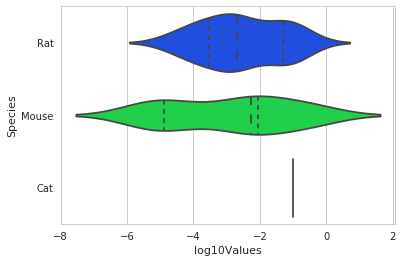

In [9]:
sns.violinplot(x="log10Values", y="Species", data=resultOneSpecies, 
               inner="quart")

### Violin plot showing the distribution of the log10 of the conductances cell types (regardless of current types or species).

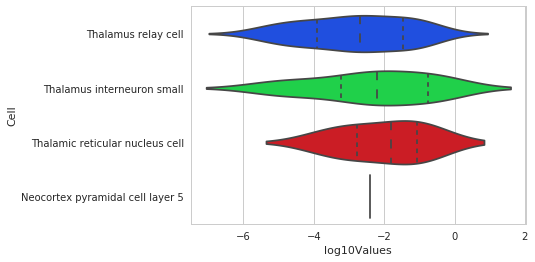

In [10]:
sns.violinplot(x="log10Values", y="Cell", data=resultOneSpecies, 
               inner="quart")

# Looking a resting membrane potentials

In [11]:
searcher = ParameterSearch(pathDB="neurocuratorDB")
searcher.setSearchConditions(ConditionAtom("Parameter name", "resting_membrane_potential"))
searcher.expandRequiredTags = True
searcher.onlyCentralTendancy = True

resultDF2 = searcher.search()
del resultDF2["obj_parameter"]
del resultDF2["obj_annotation"]
del resultDF2["Context"]
del resultDF2["Parameter instance ID"]
del resultDF2["Text"]
del resultDF2["Parameter type ID"]
del resultDF2["Result type"]

resultOneSpecies = resultDF2.reset_index()
resultOneSpecies["Species"] = [simpleSpecies(s) for s in resultOneSpecies["Species"]]
resultOneSpecies = resultOneSpecies[[len(s) == 1 for s in resultOneSpecies["Species"]]].reset_index()
resultOneSpecies["Species"] = [s[0] for s in resultOneSpecies["Species"]]
resultOneSpecies["Cell"] = [simpleCell(s) for s in resultOneSpecies["Cell"]]

resultOneSpecies.head()

,level_0,index,AgeCategories,Cell,Parameter name,Species,Unit,Values
0,0,0,[],Thalamus interneuron small,resting_membrane_potential,Mouse,mV,-69
1,1,1,[],Thalamus relay cell,resting_membrane_potential,Rat,mV,-74.4
2,2,2,[],Thalamus relay cell,resting_membrane_potential,Rat,mV,-71.4
3,3,3,[],Thalamus interneuron small,resting_membrane_potential,Rat,mV,-54.5
4,5,5,[],Thalamus relay cell,resting_membrane_potential,Cat,mV,-61.9


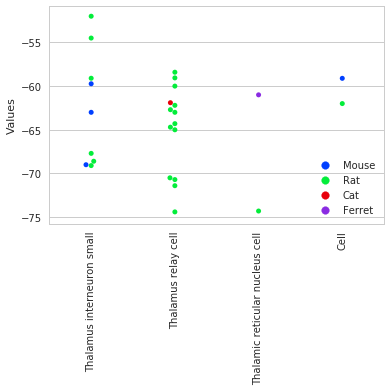

In [12]:
%matplotlib inline
import seaborn as sns
resultOneSpecies["Values"] = [np.mean(val) for val in resultOneSpecies["Values"]]
#g = sns.violinplot(x="Cell", y="Values", hue="Species", data=resultOneSpecies, bw=0.4)
g = sns.swarmplot(y="Values", x="Cell", hue="Species",
              data=resultOneSpecies)#, #resultOneSpecies[np.in1d(resultOneSpecies["Species"], ["Rat", "Mouse"])],
              #palette={"Mouse": "b", "Rat": "y"})


g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel("")
plt.legend(loc="lower right")

In [13]:
formula = "Values ~ Species + Cell"
lm = ols(formula, data=resultOneSpecies).fit()
table = sm.stats.anova_lm(lm, typ=2) # Type 2 ANOVA DataFrame
table

,sum_sq,df,F,PR(>F)
Species,100.922516,3.0,1.021971,0.403889
Cell,157.103279,3.0,1.590873,0.222961
Residual,658.352299,20.0,NaN,NaN


In [14]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Values   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                    0.9195
Date:                Wed, 10 Oct 2018   Prob (F-statistic):              0.502
Time:                        11:54:07   Log-Likelihood:                -81.429
No. Observations:                  27   AIC:                             176.9
Df Residuals:                      20   BIC:                             185.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                 -56.8077      7.430     -7.646      0.000     -72.306     -41.310
Species[T.Ferret]                          10.0946     10.064      1.003      0.328     -10.899      31.088
Species[T.Mouse]                           -4.2893      6.973     -0.615      0.545     -18.834      10.255
Species[T.Rat]                             -3.2054      5.954     -0.538      0.596     -15.625       9.214
Cell[T.Thalamic reticular nucleus cell]   -14.2869      7.257     -1.969      0.063     -29.425       0.851
Cell[T.Thalamus interneuron small]         -2.1514      4.526     -0.475      0.640     -11.592       7.289
Cell[T.Thalamus relay cell]                -5.0923      4.720     -1.079      0.294     -14.939       4.754
==============================================================================
Omnibus:                        0.757   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.685   Jarque-Bera (JB):                0.705
Skew:                          -0.021   Prob(JB):                        0.703
Kurtosis:                       2.210   Cond. No.                         17.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""